<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd

url = 'https://github.com/KubaWinsztal/MachineLearning/blob/main/diabetes.csv?raw=True'

df = pd.read_csv(url)

# Wyświetl pierwsze wiersze
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Metrics @ 0.5 threshold:
Accuracy: 0.76
Precision: 0.74
Recall/Sensitivity: 0.49
Specificity: 0.91
F1-Score: 0.59

Metrics @ optimal threshold:
Optimal Threshold: 0.30
Accuracy: 0.78
Precision: 0.67
Recall/Sensitivity: 0.71
Specificity: 0.81
F1-Score: 0.69


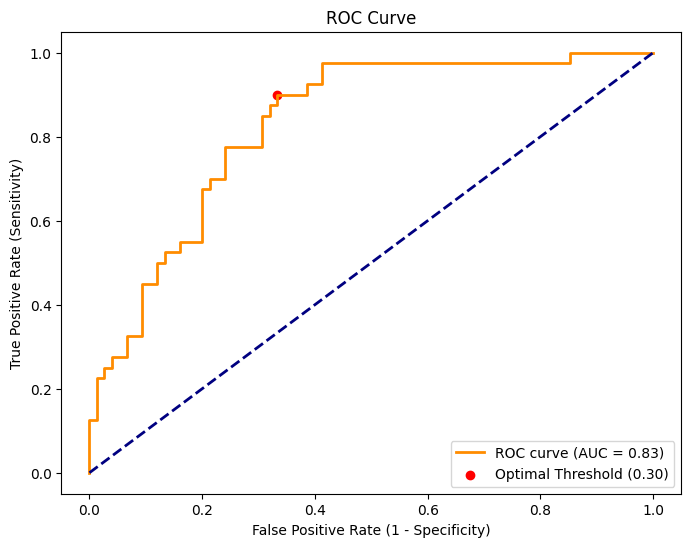

In [18]:
# Import niezbędnych bibliotek
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix)

# Podział na cechy i target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Podział na train (70%), validation (15%) i test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 2. Trenowanie modelu
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# 3. Ocena na zbiorze walidacyjnym
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

# Obliczanie ROC i AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

# Znajdowanie optymalnego progu (Youden's J-statistic)
J = tpr - fpr
ix = np.argmax(J)
optimal_threshold = thresholds[ix]

# 4. Ocena na zbiorze testowym
# Dla domyślnego progu 0.5
y_test_pred = model.predict(X_test_scaled)

# Obliczanie Specificity dla progu 0.5
tn_default, fp_default, fn_default, tp_default = confusion_matrix(y_test, y_test_pred).ravel()
specificity_default = tn_default / (tn_default + fp_default)

print("Metrics @ 0.5 threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall/Sensitivity: {recall_score(y_test, y_test_pred):.2f}")
print(f"Specificity: {specificity_default:.2f}")  # Nowa metryka
print(f"F1-Score: {f1_score(y_test, y_test_pred):.2f}\n")

# Dla optymalnego progu
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Obliczanie Specificity dla optymalnego progu
tn_optimal, fp_optimal, fn_optimal, tp_optimal = confusion_matrix(y_test, y_test_optimal).ravel()
specificity_optimal = tn_optimal / (tn_optimal + fp_optimal)

print("Metrics @ optimal threshold:")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_optimal):.2f}")
print(f"Precision: {precision_score(y_test, y_test_optimal):.2f}")
print(f"Recall/Sensitivity: {recall_score(y_test, y_test_optimal):.2f}")
print(f"Specificity: {specificity_optimal:.2f}")
print(f"F1-Score: {f1_score(y_test, y_test_optimal):.2f}")

# 5. Wizualizacja ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ODPOWIEDZI NA PYTANIA:

1. Czy inny próg klasyfikacji dałby lepsze wyniki?
Tak, zmiana progu z domyślnego 0.5 na 0.30 poprawiła kluczowe metryki w kontekście wykrywania chorób:

Czułość (Recall/Sensitivity) wzrosła z 49% do 71% – model lepiej wykrywa osoby chore.

Specificity utrzymała się na wysokim poziomie (81%), co oznacza, że model nie generuje nadmiarowo fałszywie pozytywnych wyników.

F1-Score wzrósł z 0.59 do 0.69, co wskazuje na lepszą równowagę między precyzją a czułością.

Trade-off między czułością a specyficznością:

Obniżenie progu zwiększa czułość (wykrywanie chorych), ale obniża precyzję (więcej fałszywych pozytywów).

Podwyższenie progu zwiększa specyficzność (mniej fałszywych pozytywów), ale obniża czułość (więcej fałszywych negatywów).

2. Jak definiujemy „lepsze” wyniki?
Definicja zależy od kontekstu zadania:

Wykrywanie chorób (np. cukrzycy):

Priorytet: Wysoka czułość, aby nie przeoczyć chorych pacjentów. Nawet kosztem niższej precyzji.

Dlaczego? Fałszywe negatywy (niezdiagnozowana choroba) są groźniejsze niż fałszywe pozytywy (dodatkowe testy).

Filtrowanie spamu:

Priorytet: Wysoka precyzja, aby nie usuwać prawidłowych wiadomości.

Dlaczego? Fałszywe pozytywy (spam w głównej skrzynce) są mniej problematyczne niż usunięcie ważnej wiadomości.

W tym zadaniu optymalny próg (0.30) został dobrany pod kątem
 cukrzycy, gdzie czułość jest kluczowa.

3. Jak krzywa ROC pomaga w doborze progu?

Krzywa ROC (Receiver Operating Characteristic) to narzędzie, które pozwala analizować kompromis między czułością (TPR) a fałszywie dodatnimi wynikami (FPR) dla różnych progów klasyfikacji. Jest kluczowa w kontekście zadań, gdzie koszty błędów są asymetryczne (np. wykrywanie chorób).

Interpretacja wyników (AUC = 0.83):
Kształt krzywej: Im bardziej krzywa przylega do lewego górnego rogu, tym lepsza jakość modelu. Nasza krzywa znajduje się wyraźnie powyżej linii losowej, co oznacza, że model dobrze rozróżnia klasy.

Optymalny próg (0.30): Zaznaczony punkt na krzywej odpowiada najlepszemu kompromisowi między TPR a FPR w zadaniu.

Jak krzywa ROC pomaga w praktyce?
Wybór progu zgodnie z celem zadania:

Wykrywanie chorób (np. cukrzycy): Przesuń próg w lewo na krzywej (np. 0.30), aby zwiększyć czułość (TPR), nawet kosztem wyższego FPR.

Filtrowanie spamu: Przesuń próg w prawo, aby zwiększyć specyficzność (mniej fałszywych pozytywów).

4. Jak wybrać optymalny próg za pomocą ROC?

Strategie wyboru progu:

- Maksymalizacja wskaźnika Youdena (J = TPR – FPR): Wybrano próg 0.30, gdzie J osiąga maksimum.

- Minimalizacja odległości euklidesowej do punktu (0,1) na ROC: Punkt idealny (czułość=100%, specyficzność=100%).

W tym zadaniu wybrałem pierwszą strategię, co dało najlepszy wynik pod kątem czułości (z 49% na 71%), która jest dla nas kluczowa ze względu na konteks problemu, mimo drobnego obniżenia dokładności z 78% na 76%.


5. Czym jest metryka AUC i jak może być pomocna?

Z krzywą ROC ściśle wiąże się miara AUC, czyli pole pod tą krzywą. AUC przyjmuje wartości od 0 do 1 i obrazuje, jak dobrze model potrafi odróżnić jedną klasę od drugiej. Można ją rozumieć jako prawdopodobieństwo, że model przypisze wyższe prawdopodobieństwo przypadkowo wybranej obserwacji pozytywnej niż negatywnej. Dla przykładu, w zadaniu klasyfikacji wiadomości jako spam lub nie-spam, AUC bliskie 1 oznacza, że model niemal zawsze trafnie ocenia, że wiadomość będąca spamem ma większą szansę bycia spamem niż wiadomość, która nim nie jest.